In [47]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [49]:
%matplotlib inline

In [50]:
TEXT_COLOUR = {
    'PURPLE':'\033[95m',
    'CYAN':'\033[96m',
    'DARKCYAN':'\033[36m',
    'BLUE':'\033[94m',
    'GREEN':'\033[92m',
    'YELLOW':'\033[93m',
    'RED':'\033[91m',
    'BOLD':'\033[1m',
    'UNDERLINE':'\033[4m',
    'END':'\033[0m'
}

def print_bold(*msgs):
    print(TEXT_COLOUR['BOLD'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_green(*msgs):
    print(TEXT_COLOUR['GREEN'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_error(*msgs):
    print(TEXT_COLOUR['RED'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def wrap_green(msg):
    return TEXT_COLOUR['GREEN'] + msg + TEXT_COLOUR['END']

def wrap_red(msg):
    return TEXT_COLOUR['RED'] + msg + TEXT_COLOUR['END']

def up_down_str(val):
    msg = str(val)
    if val > 0:
        msg = wrap_green(msg)
    elif val < 0:
        msg = wrap_red(msg)
    return msg

In [51]:
exp='roberta-base'
num_layers = 12

In [52]:
tasks = ["CoLA","SST-2","MRPC","STS-B","QQP","MNLI", "MNLI-MM", "QNLI","RTE"]
tasks = ["CoLA","SST-2","MRPC","STS-B","RTE"]

metrics = {
    "CoLA":["mcc"],
    "MNLI":["acc"],
    "MNLI-MM":["acc"],
    "MRPC":["f1"],
    "QNLI":["acc"],
    "QQP":["f1"],
    "RTE":["acc"],
    "SST-2":["acc"],
    "STS-B":["spearmanr"],
    "WNLI":["acc"] #temp
}

reported_in_paper = {
    "CoLA":0.00,
    "MNLI":0.00,
    "MNLI-MM":0.0,
    "MRPC":0.00,
    "QNLI":0.00,
    "QQP":0.00,
    "RTE":0.00,
    "SST-2":0.00,
    "STS-B":0.00,
    "WNLI":0.00
}

In [53]:

def get_average_val(lines):
    reported = []
    for line in lines:
        val = float(line.split('\t')[1])
        if val != 0:
            reported.append(val)
    out = 0
    if len(reported) != 0:
        reported.sort(reverse = True)
        candidates = [reported[0]]
        for j in range(1, len(reported)):
            if reported[j] > 0.9 * reported[0]:
                candidates.append(reported[j])
        out = np.mean(candidates)
        
    return out


In [54]:
results = {}

for task in tasks:
    task_results = {}
    task_metrics = metrics[task]
    for metric in task_metrics:
        
        # base metrics
        print(f"../exp_results/{exp}/{task}/base-{metric}.txt")
        f=open(f"../exp_results/{exp}/{task}/base-{metric}.txt", "r")
        lines = f.read().splitlines()
        task_results[f'base-{metric}'] = get_average_val(lines)
        
        # no layer metrics
        
        fine_tuning_metrics = []
        f=open(f"../exp_results/{exp}/{task}/no_layer-{metric}.txt", "r")

        lines = f.read().splitlines()
        fine_tuning_metrics.append(get_average_val(lines))
        
        # fine-tuned metrics
        
        log_file_prefix=''
        for i in reversed(range(int(num_layers/2), num_layers)):
            log_file_prefix += str(i)
            f=open(f"../exp_results/{exp}/{task}/{log_file_prefix}-{metric}.txt", "r")
            lines = f.read().splitlines()
            fine_tuning_metrics.append(get_average_val(lines))
            
            log_file_prefix +='_'
        
        task_results[f'{metric}'] = list(reversed(fine_tuning_metrics))
        
    results[task] = task_results

../exp_results/roberta-base/CoLA/base-mcc.txt
../exp_results/roberta-base/SST-2/base-acc.txt
../exp_results/roberta-base/MRPC/base-f1.txt
../exp_results/roberta-base/STS-B/base-spearmanr.txt
../exp_results/roberta-base/RTE/base-acc.txt


In [55]:
x_axis = []

for i in range(int(num_layers/2), num_layers):
    x_axis.append(str(i))

x_axis.append("none")

In [56]:
def draw_graph(task, y_label, paper, base, reported):
    plt.figure(figsize=(10,6))
    plt.plot(x_axis, reported)
    
    plt.xlabel("layers")
    plt.ylabel(y_label)
    
    if paper == 0.0:    
        gap = max(reported) - min(reported)
        top = max(max(reported), base) + (gap*0.2)
        bottom = min(min(reported), base) - (gap*0.2)
    
        plt.ylim(bottom, top)

        plt.axhline(y=base, linestyle='--', c='green')
    else:
        gap = max(reported) - min(reported)
        top = max(max(reported), base, paper) + (gap*0.2)
        bottom = min(min(reported), base, paper) - (gap*0.2)
    
        plt.ylim(bottom, top)

        plt.axhline(y=base, linestyle='--', c='green')
        plt.axhline(y=paper, linestyle='--', c='red')
    
    plt.title(f'{exp}-{task} ({round(base,4)})')
    plt.savefig(f'images/{exp}/{task}', format='png', bbox_inches='tight')
    plt.show()


CoLA mcc 59.76 58.34 0



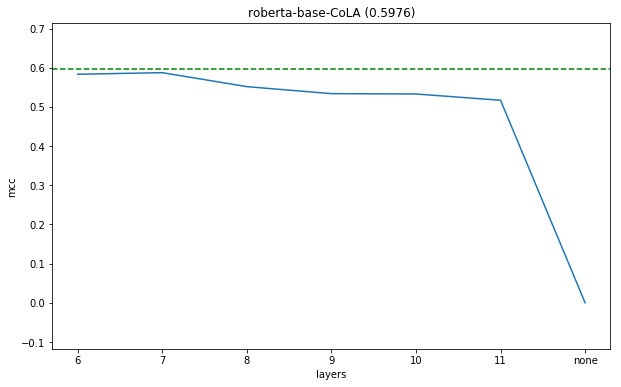


SST-2 acc 94.72 94.07 80.05



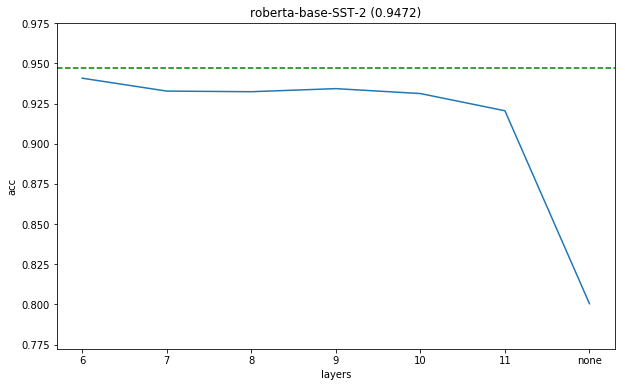


MRPC f1 92.43 90.56 81.22



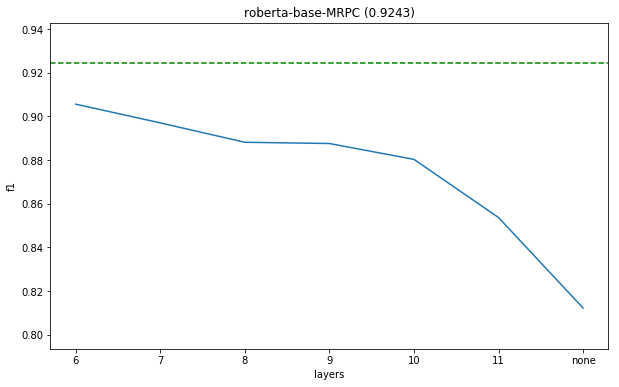


STS-B spearmanr 90.61 88.92 19.79



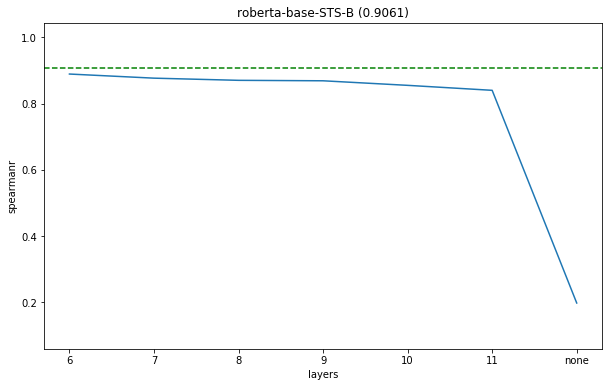


RTE acc 78.7 74.37 58.48



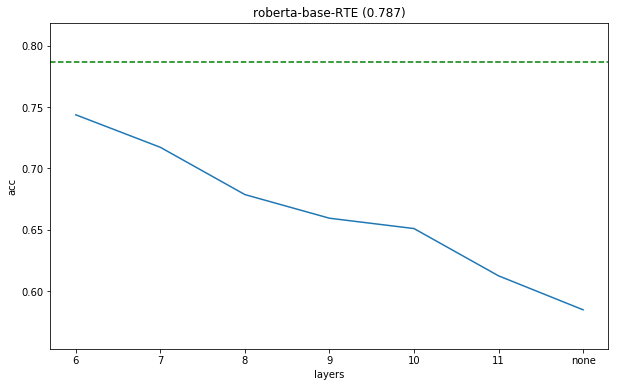

In [57]:
for task in tasks:
    task_results = results[task]
    task_metrics = metrics[task]
    for metric in task_metrics:
        reported = task_results[metric]
        base = task_results[f'base-{metric}']
        print_bold(task, metric, round(base * 100, 2), round(task_results[metric][0] * 100, 2), round(task_results[metric][-1] * 100, 2))
        draw_graph(task, metric, reported_in_paper[task], base, reported)